# Training With Additional Dataset
<p>Additional dataset from Allen's own keystroke dynamic is captured and added into the benchmark dataset for training and more in depth evaluation using Support Vector Machine and Gradient Boost Ensemble algorithm.
These 2 algorithms are identified to have the highest accuracy results among all the other models evaluated in the inital screening exercise.</p>
<p>The following exercise will attempt to incorporate our own captured keystroke data and performance hyperparameter tuning using these 2 algorithms to derive the best performing algorithm for our finalised model for deployment. </p>

In [1]:
# Import all required libraries
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import model selection and data preparation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

# Import algorithm libraries
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# serialisation library
import pickle

## Loading of Datasets

#### 1) Loading Allen's keystroke data

In [2]:
# Loading Allen's keystroke data 
new_df = pd.read_csv('./Keystroke Data/Allen-keystroke_combined.csv')

# Get the dataframe for feature columns only
# Conversion from millisec to second
new_features = new_df.drop(['User','Session', 'Sequence'], axis=1) / 1000.0
new_target = new_df['User']

new_features

H.period  UD.period.t    H.t  UD.t.i    H.i  UD.i.e    H.e  UD.e.five  \
0       0.131        0.131  0.091   0.063  0.091   0.100  0.101      0.161   
1       0.131        0.134  0.082   0.070  0.071   0.019  0.091      0.144   
2       0.121        0.115  0.081   0.070  0.071   0.019  0.091      0.265   
3       0.121        0.130  0.092   0.073  0.081   0.029  0.081      0.191   
4       0.122        0.090  0.091   0.063  0.081   0.040  0.101      0.161   
..        ...          ...    ...     ...    ...     ...    ...        ...   
409     0.144       -0.003  0.118   0.080  0.092   0.069  0.092      0.137   
410     0.132        0.049  0.102   0.107  0.091   0.090  0.112      0.127   
411     0.123        0.120  0.098   0.070  0.102   0.060  0.111      0.137   
412     0.121        0.161  0.111   0.051  0.088   0.060  0.122      0.111   
413     0.129        0.069  0.081   0.080  0.092   0.039  0.099      0.150   

     H.five  UD.five.Shift.r  ...  UD.Shift.r.o    H.o  UD.o.a    H.a  UD.a.n  \
0     0.115            0.321  ...         0.003  0.088   0.090  0.132   0.003   
1     0.071            0.342  ...         0.130  0.082   0.059  0.112   0.080   
2     0.101            0.347  ...         0.121  0.080   0.060  0.125   0.060   
3     0.124            0.292  ...         0.123  0.081   0.080  0.111   0.070   
4     0.095            0.312  ...         0.144  0.090   0.050  0.111   0.030   
..      ...              ...  ...           ...    ...     ...    ...     ...   
409   0.091            0.292  ...         0.070  0.091   0.071  0.120   0.050   
410   0.091            0.334  ...         0.110  0.082   0.069  0.082   0.070   
411   0.112            0.312  ...         0.070  0.112   0.029  0.112   0.060   
412   0.101            0.289  ...         0.101  0.098   0.070  0.101   0.050   
413   0.082            0.258  ...         0.003  0.077   0.080  0.112   0.003   

       H.n  UD.n.l    H.l  UD.l.Return  H.Return  
0    0.077   0.154  0.071        0.130     0.071  
1    0.074   0.180  0.072        0.181     0.073  
2    0.062   0.170  0.062        0.193     0.071  
3    0.071   0.164  0.081        0.090     0.081  
4    0.082   0.143  0.051        0.150     0.051  
..     ...     ...    ...          ...       ...  
409  0.088   0.172  0.101        0.120     0.072  
410  0.098   0.150  0.081        0.131     0.061  
411  0.098   0.142  0.081        0.101     0.091  
412  0.102   0.157  0.071        0.120     0.062  
413  0.057   0.147  0.063        0.120     0.071  

[414 rows x 21 columns]

#### 2) Loading benchmark keystroke data

In [3]:
# Loading benchmark dataset and only taking data from first 10 subjects
benchmark_df = pd.read_csv('./Keystroke Data/DSL-StrongPasswordData.csv')
first_10subject = (benchmark_df.groupby(by='subject', axis=0).count().index[:10])
selected_dataset = benchmark_df[benchmark_df['subject'].isin(first_10subject)]

# The DD and UD timings of each key have been showed to be highly correlated to each other 
# in a separate analysis. Hence, we will drop all features starting with 'DD'
all_features = selected_dataset.columns[3:34]
benchmark_features = [x for x in all_features if not x.startswith('DD')]
benchmark_target = selected_dataset['subject']



#### 3) Consolidating dataset

In [4]:
# Get a copy of dataset with selected feature columns
df = selected_dataset[benchmark_features].copy()

# Concatenate both DataFrame for feature columns
df = pd.concat([df, new_features])

# Concatenate both target columns
df_target = pd.concat([benchmark_target, new_target ])


# check for invalid/missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4414 entries, 0 to 413
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   H.period         4414 non-null   float64
 1   UD.period.t      4414 non-null   float64
 2   H.t              4414 non-null   float64
 3   UD.t.i           4414 non-null   float64
 4   H.i              4414 non-null   float64
 5   UD.i.e           4414 non-null   float64
 6   H.e              4414 non-null   float64
 7   UD.e.five        4414 non-null   float64
 8   H.five           4414 non-null   float64
 9   UD.five.Shift.r  4414 non-null   float64
 10  H.Shift.r        4414 non-null   float64
 11  UD.Shift.r.o     4414 non-null   float64
 12  H.o              4414 non-null   float64
 13  UD.o.a           4414 non-null   float64
 14  H.a              4414 non-null   float64
 15  UD.a.n           4414 non-null   float64
 16  H.n              4414 non-null   float64
 17  UD.n.l         

<b>Observation</b>: No missing or invalid features data points.

#### 4) Encoding target labels

In [5]:
# Encode all target labels into integers
enc = LabelEncoder()
df_target_int = enc.fit_transform(df_target)

print("Classes:", enc.classes_)


Classes: ['Allen' 's002' 's003' 's004' 's005' 's007' 's008' 's010' 's011' 's012'
 's013']


#### 5) Dataset visualisations

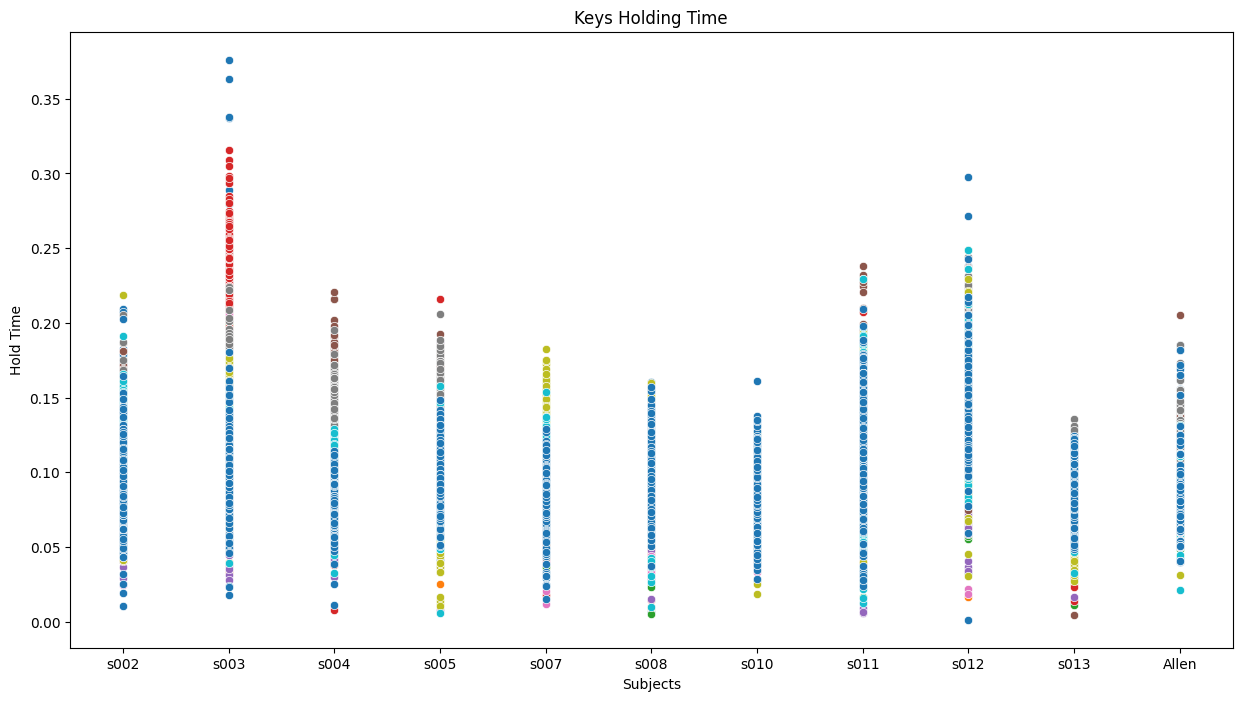

In [6]:
# Plot scatter graph for visualisation on Hold time
# Select only the hold times
hold_col = [x for x in df.columns if x.startswith('H')]

hold_dataset = df[hold_col]
hold_dataset.index = df_target

# creating subplots to overlay the timings
fig, ax = plt.subplots(figsize=(15,8))

for h in hold_col:
    ax = sns.scatterplot(hold_dataset, x=hold_dataset.index, y=h)
    
ax.set(xlabel="Subjects", ylabel="Hold Time", title='Keys Holding Time')
plt.show()

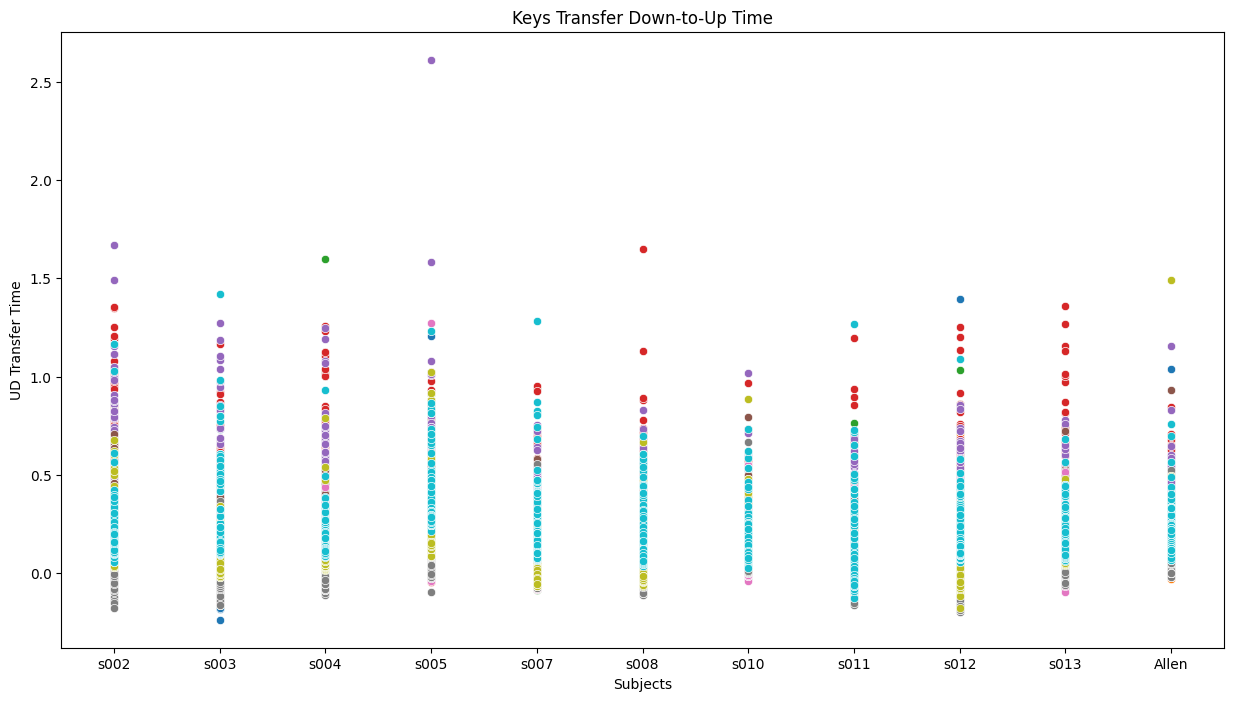

In [7]:
# Plot scatter graph for visualisation on UD time
# Select only the UD times
UD_col = [x for x in df.columns  if x.startswith('UD')]

UD_dataset = df[UD_col]
UD_dataset.index = df_target

# creating subplots to overlay the timings
fig, ax = plt.subplots(figsize=(15,8))

for h in UD_dataset:
    ax = sns.scatterplot(UD_dataset, x=UD_dataset.index, y=h)
    
ax.set(xlabel="Subjects", ylabel="UD Transfer Time", title='Keys Transfer Down-to-Up Time')
plt.show()

## Splitting Data into Training and Test Sets & Scaling

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, df_target_int, test_size=0.25, random_state=42,
                                                   stratify=df_target_int)

# Applying scaling to training dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)



## Creation of Experiment for MLFlow Logging

### A) Suport Vector Classifier

### 1) Using RBF Kernel

In [95]:
mlflow.sklearn.autolog()

experiment_name = "Evaluation Experiment on SVM"
experiment = mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name="RBF Kernel", experiment_id=experiment.experiment_id):

    # Create Pipeline for scaling and SVC model on rgf kernel
    mypipeline = Pipeline([("scaler", StandardScaler()),("svm", SVC(random_state=42))])

    # Run grid search
    param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

    grid = GridSearchCV(mypipeline, param_grid=param_grid, cv=10)
    grid.fit(X_train, y_train)


    run_id = mlflow.last_active_run().info.run_id
    print("Logged data and model in run {}".format(run_id))


2023/08/14 22:59:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, 31 runs will be omitted.


Logged data and model in run 4326feb43a7145fe87dc32ec5b94e715


In [96]:
# Print results of run
print("Best cross validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))


Best cross validation accuracy: 0.94
Test set score: 0.93
Best parameters: {'svm__C': 10, 'svm__gamma': 0.01}


2023/08/14 23:01:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7835918ec7bb49dfabbda575dfcc8721', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Confusion matrix:
[[96  4  0  0  3  0  1  0  0  0  0]
 [ 2 90  3  0  1  1  1  0  1  1  0]
 [ 1  2 90  2  0  1  1  0  2  1  0]
 [ 0  6  1 91  0  1  0  0  1  0  0]
 [ 0  1  2  0 96  0  0  0  1  0  0]
 [ 0  1  1  0  0 92  5  0  1  0  0]
 [ 2  0  1  1  0  2 93  0  1  0  0]
 [ 1  0  0  0  0  0  0 98  0  0  1]
 [ 0  2  1  0  0  2  1  0 91  3  0]
 [ 0  2  3  0  0  1  1  0  0 93  0]
 [ 0  2  0  0  0  0  1  2  0  0 95]]


[Text(0.5, 23.52222222222222, 'Predicted Class'),
 Text(50.722222222222214, 0.5, 'True Class'),
 Text(0.5, 1.0, 'Confusion Matrix')]

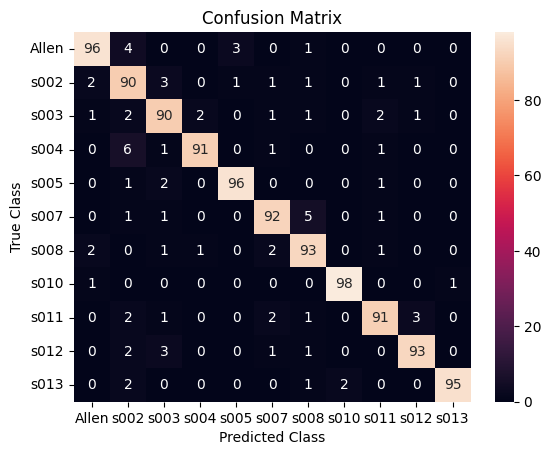

In [97]:
# Measure confusion matric on test data
best_pipeline = Pipeline([("scaler", StandardScaler()),("svm", SVC(C=grid.best_params_['svm__C']
                                                                   ,gamma=grid.best_params_['svm__gamma']
                                                                   ,kernel='rbf'))])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

print("Confusion matrix:\n{}".format(confusion_matrix(y_test,y_pred)))

score_image1 = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, xticklabels=enc.classes_,
                          yticklabels=enc.classes_)
score_image1.set(xlabel='Predicted Class', ylabel='True Class', title='Confusion Matrix')


In [98]:
# Classification reporting
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       104
           1       0.82      0.90      0.86       100
           2       0.88      0.90      0.89       100
           3       0.97      0.91      0.94       100
           4       0.96      0.96      0.96       100
           5       0.92      0.92      0.92       100
           6       0.89      0.93      0.91       100
           7       0.98      0.98      0.98       100
           8       0.93      0.91      0.92       100
           9       0.95      0.93      0.94       100
          10       0.99      0.95      0.97       100

    accuracy                           0.93      1104
   macro avg       0.93      0.93      0.93      1104
weighted avg       0.93      0.93      0.93      1104



### 2) Using polynomial kernel

In [100]:
with mlflow.start_run(run_name="Polynomial Kernel", experiment_id=experiment.experiment_id):

    # Create Pipeline for scaling and SVC model on polynomial kernel
    mypipeline2 = Pipeline([("scaler", StandardScaler()),("svm", SVC(kernel='poly', random_state=42))])

    # Run grid search
    param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
             'svm__degree': [1, 2, 3, 4, 5]}
    grid = GridSearchCV(mypipeline2, param_grid=param_grid, cv=10)
    grid.fit(X_train, y_train)


    run_id = mlflow.last_active_run().info.run_id
    print("Logged data and model in run {}".format(run_id))


2023/08/14 23:17:30 INFO mlflow.sklearn.utils: Logging the 5 best runs, 25 runs will be omitted.


Logged data and model in run f2bfb840c1db4aa0a9596d51e72ac45d


In [101]:
# Print results of run
print("Best cross validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))


Best cross validation accuracy: 0.93
Test set score: 0.93
Best parameters: {'svm__C': 10, 'svm__degree': 3}


2023/08/14 23:21:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '246a06941e8140e5aceecdd1e2244415', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Confusion matrix:
[[ 97   5   0   0   2   0   0   0   0   0   0]
 [  1  89   4   1   3   0   1   0   0   1   0]
 [  0   2  83   8   2   0   2   0   1   2   0]
 [  0   5   0  93   0   1   0   0   1   0   0]
 [  0   0   0   0 100   0   0   0   0   0   0]
 [  0   1   0   1   1  92   4   0   1   0   0]
 [  2   1   0   0   0   1  94   0   2   0   0]
 [  0   0   0   0   0   0   0 100   0   0   0]
 [  1   1   1   0   0   0   2   0  93   2   0]
 [  0   0   6   0   0   1   2   0   2  89   0]
 [  1   1   0   0   0   0   3   1   0   0  94]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       104
           1       0.85      0.89      0.87       100
           2       0.88      0.83      0.86       100
           3       0.90      0.93      0.92       100
           4       0.93      1.00      0.96       100
           5       0.97      0.92      0.94       100
           6       0.87      0.94      0.90       100
           7       0.99      1.

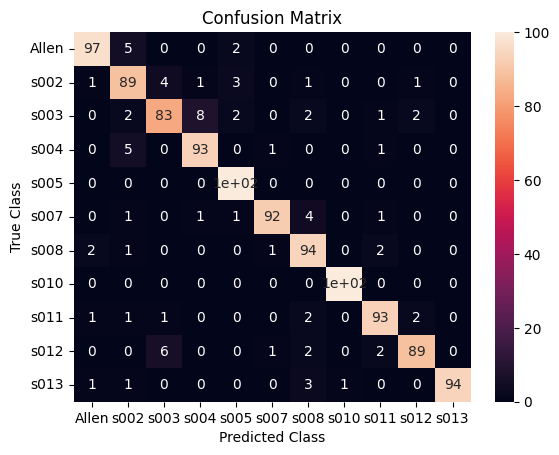

In [104]:
# Measure confusion matric on test data
best_pipeline = Pipeline([("scaler", StandardScaler()),("svm", SVC(C=grid.best_params_['svm__C']
                                                                   ,degree=grid.best_params_['svm__degree']
                                                                   ,kernel='poly'))])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

print("Confusion matrix:\n{}".format(confusion_matrix(y_test,y_pred)))

score_image1 = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, xticklabels=enc.classes_,
                          yticklabels=enc.classes_)
score_image1.set(xlabel='Predicted Class', ylabel='True Class', title='Confusion Matrix')

# Classification reporting
print(classification_report(y_test, y_pred))

### B) Gradient Boost Ensemble

<b>Note</b>: <i>This grid search took around 2 hrs to complete.  Keep this in mind before re-running.</i>

In [14]:
mlflow.sklearn.autolog()

experiment_name = "Evaluation Experiment on Gradient Boosting Ensemble"
experiment = mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name="Gradient Boost Classifier", experiment_id=experiment.experiment_id):

    # Instantiate sklearn Gradient Boost Ensemble model
    clf = GradientBoostingClassifier(random_state=42)
    
    # Run grid search
    param_grid = {'n_estimators': [100, 200, 300],
                 'learning_rate': [0.01, 0.1, 1, 10],
                 'subsample': [0.8, 0.9, 1.0]}

    grid = GridSearchCV(clf, param_grid=param_grid, cv=10)
    grid.fit(X_train_scaled, y_train)


    run_id = mlflow.last_active_run().info.run_id
    print("Logged data and model in run {}".format(run_id))


2023/08/16 21:53:20 INFO mlflow.tracking.fluent: Experiment with name 'Evaluation Experiment on Gradient Boosting Ensemble' does not exist. Creating a new experiment.
2023/08/16 23:57:36 INFO mlflow.sklearn.utils: Logging the 5 best runs, 31 runs will be omitted.


Logged data and model in run 76ada3ddf52047ca90c66eb94e05a671


In [17]:
# Print results of run
print("Best cross validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(scaler.transform(X_test), y_test)))
print("Best parameters: {}".format(grid.best_params_))


Best cross validation accuracy: 0.97
Test set score: 0.97
Best parameters: {'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.9}


<b>Conclusions</b>:  Best hyperparameters to use are learning rate of 0.1, estimator count of 300 and sample fraction of 0.9 used for fitting individual base models.  For a value of 0.9, this is actually a stochastic gradient boosting algorithm.

Confusion matrix:
[[100   2   0   1   0   0   1   0   0   0   0]
 [  0  97   0   0   1   0   1   0   0   1   0]
 [  0   1  98   0   0   0   0   0   0   1   0]
 [  1   7   0  92   0   0   0   0   0   0   0]
 [  0   0   1   0  99   0   0   0   0   0   0]
 [  0   0   0   0   2  97   1   0   0   0   0]
 [  0   0   0   1   0   0  97   0   1   0   1]
 [  0   0   0   0   0   0   0 100   0   0   0]
 [  0   1   0   0   0   1   2   0  94   2   0]
 [  0   0   2   0   0   0   2   0   0  96   0]
 [  0   1   0   0   0   0   3   0   0   0  96]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       104
           1       0.89      0.97      0.93       100
           2       0.97      0.98      0.98       100
           3       0.98      0.92      0.95       100
           4       0.97      0.99      0.98       100
           5       0.99      0.97      0.98       100
           6       0.91      0.97      0.94       100
           7       1.00      1.

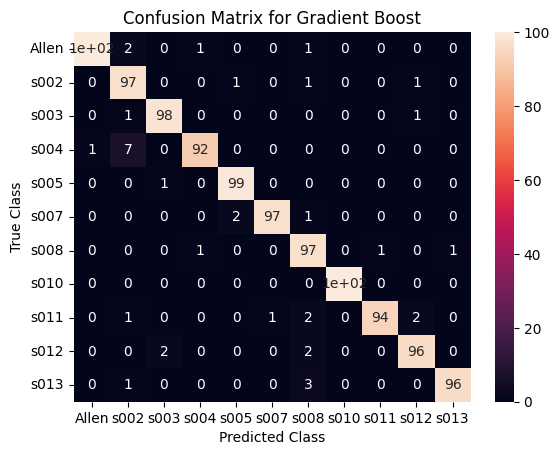

In [10]:
clf = GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=300, subsample=0.9)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(scaler.transform(X_test))

print("Confusion matrix:\n{}".format(confusion_matrix(y_test,y_pred)))

score_image1 = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, xticklabels=enc.classes_,
                          yticklabels=enc.classes_)
score_image1.set(xlabel='Predicted Class', ylabel='True Class', title='Confusion Matrix for Gradient Boost')

# Classification reporting
print(classification_report(y_test, y_pred))

<b>Observation</b>: Gradient Boost Ensemble achieved a high accuracy of 0.97 for average F1 Score across the classes of 11 subjects, with each achieving FI score above 0.90 on the test dataset.  This is a good enough performance for production deployment.  This will be the finalised model to be deployed.

## Error Analysis on Finalised Model Predictions

Although the Gradient Boost Ensemble model produce high accuracy score on the test dataset, there is some specific class, namely Subject 's002' that has relatively higher number of mis-classification. There are 7 samples under 'S004' that are incorrectly predicted as 'S002' by the final trained model.

This section attempts to analyse the wrongly classified test samples to have a better understanding on the reason. 

In [12]:
# Retrieve dataset related to subject 's004' from X_test - WIP
df1 = X_test.copy()
df1['subject'] = y_test

df_s004 = df1[df1['subject'] == 3]   

X_s004 = df_s004.drop(['subject'], axis=1)
y_s004 = clf.predict(scaler.transform(X_s004))


In [13]:
print(y_s004)

[3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 1 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 1 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 1 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [14]:
# stored the predicted results
df_s004['predicted'] = y_s004

# check wrong data point
wrong_s004 = df_s004[df_s004['subject'] != df_s004['predicted']]

wrong_s004

/tmp/ipykernel_5211/3797126090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s004['predicted'] = y_s004


H.period  UD.period.t     H.t  UD.t.i     H.i  UD.i.e     H.e  \
1084    0.1045       0.0659  0.1082  0.0343  0.1093  1.5976  0.1024   
803     0.1027       0.3198  0.0858  0.0317  0.1048  0.0584  0.0942   
1000    0.1117       0.0633  0.0921  0.0058  0.0832 -0.0048  0.0843   
854     0.1022       0.0955  0.0884  0.0372  0.0908  0.0014  0.0953   
810     0.1230       0.0807  0.1000  0.0547  0.1029  0.0510  0.0905   
808     0.1127       0.1015  0.0731  0.0370  0.0837  0.0539  0.0623   
850     0.1032       0.1944  0.0845  0.0837  0.0855  0.0436  0.0884   
801     0.1183       0.4863  0.0634  0.0737  0.0927  0.0547  0.0665   

      UD.e.five  H.five  UD.five.Shift.r  ...  UD.o.a     H.a  UD.a.n     H.n  \
1084     0.1304  0.0861           0.2085  ... -0.0187  0.1389  0.0555  0.1117   
803      0.8481  0.0832           0.8036  ...  0.0310  0.1138  0.0230  0.0824   
1000     1.1249  0.0618           0.4083  ... -0.0137  0.1201  0.0257  0.0879   
854      0.3937  0.0584           0.3806  ...  0.1051  0.1085  0.0550  0.0995   
810      1.0028  0.0892           0.6796  ...  0.0291  0.1259  0.0032  0.1008   
808      0.4950  0.0774           0.8129  ...  0.0566  0.1111  0.0325  0.0718   
850      0.7309  0.0489           0.7490  ...  0.0225  0.0924  0.0391  0.0810   
801      1.1251  0.0681           1.0794  ...  0.0231  0.0871  0.0573  0.1169   

      UD.n.l     H.l  UD.l.Return  H.Return  subject  predicted  
1084  0.1470  0.0325       0.3131    0.0792        3          0  
803   0.0815  0.0932       0.2474    0.0813        3          1  
1000  0.1657  0.1040       0.1353    0.0710        3          1  
854   0.1187  0.0803       0.1540    0.0473        3          1  
810   0.0916  0.0998       0.1427    0.0784        3          1  
808   0.0916  0.0961       0.1733    0.0805        3          1  
850   0.1042  0.0927       0.2063    0.0697        3          1  
801   0.1296  0.1006       0.3369    0.0826        3          1  

[8 rows x 23 columns]

In [23]:
# Get the correctly labelled samples
correct_s004 = df_s004[df_s004['subject'] == df_s004['predicted']]

correct_s004

H.period  UD.period.t     H.t  UD.t.i     H.i  UD.i.e     H.e  \
819     0.1051       0.1079  0.0850  0.1082  0.1077  0.0386  0.0824   
953     0.1219       0.1089  0.0800  0.0341  0.0911 -0.0011  0.0734   
835     0.1267       0.1860  0.0876  0.0520  0.1088 -0.0014  0.0735   
1120    0.0995       0.0614  0.1201  0.0211  0.1204 -0.0090  0.0919   
1129    0.1336       0.1327  0.1082  0.0225  0.1019 -0.0011  0.0808   
...        ...          ...     ...     ...     ...     ...     ...   
961     0.1119       0.0601  0.1127  0.0053  0.1017 -0.0043  0.0753   
945     0.0718       0.0327  0.1341  0.0056  0.0916 -0.0256  0.0858   
964     0.0650       0.0833  0.1143  0.0130  0.0898  0.0014  0.0694   
1022    0.1045       0.1445  0.1249  0.0204  0.1167 -0.0441  0.0608   
881     0.0934       0.0604  0.0913  0.0816  0.1014  0.0135  0.0837   

      UD.e.five  H.five  UD.five.Shift.r  ...     H.a  UD.a.n     H.n  UD.n.l  \
819      0.4523  0.0623           0.6162  ...  0.1299  0.0141  0.0948  0.0662   
953      0.3417  0.0731           0.3035  ...  0.1227  0.0734  0.0813  0.0736   
835      0.5655  0.0692           0.2650  ...  0.1204  0.0069  0.0890  0.0486   
1120     0.1343  0.1317           0.2698  ...  0.1294 -0.0032  0.0869  0.0718   
1129     0.0979  0.0890           0.3432  ...  0.1651 -0.0330  0.0690  0.0673   
...         ...     ...              ...  ...     ...     ...     ...     ...   
961      0.2528  0.0800           0.2542  ...  0.1283 -0.0190  0.0695  0.0493   
945      0.2808  0.1130           0.2556  ...  0.1533 -0.0187  0.0963  0.0515   
964      0.1330  0.0834           0.3629  ...  0.1259  0.0082  0.0884  0.0478   
1022     0.1227  0.1227           0.2518  ...  0.1320 -0.0372  0.0842  0.0570   
881      0.2370  0.0966           0.3439  ...  0.1085  0.0051  0.0755  0.0800   

         H.l  UD.l.Return  H.Return  subject  predicted  results  
819   0.0971       0.1292    0.0882        3          3  Correct  
953   0.0942       0.1440    0.0613        3          3  Correct  
835   0.1064       0.1456    0.0890        3          3  Correct  
1120  0.0768       0.1223    0.0605        3          3  Correct  
1129  0.0779       0.1089    0.0676        3          3  Correct  
...      ...          ...       ...      ...        ...      ...  
961   0.0990       0.1165    0.0787        3          3  Correct  
945   0.1043       0.0902    0.0929        3          3  Correct  
964   0.0737       0.1047    0.0800        3          3  Correct  
1022  0.0837       0.1073    0.0697        3          3  Correct  
881   0.0932       0.1147    0.0792        3          3  Correct  

[92 rows x 24 columns]

#### Comparison of Key Hold Duration

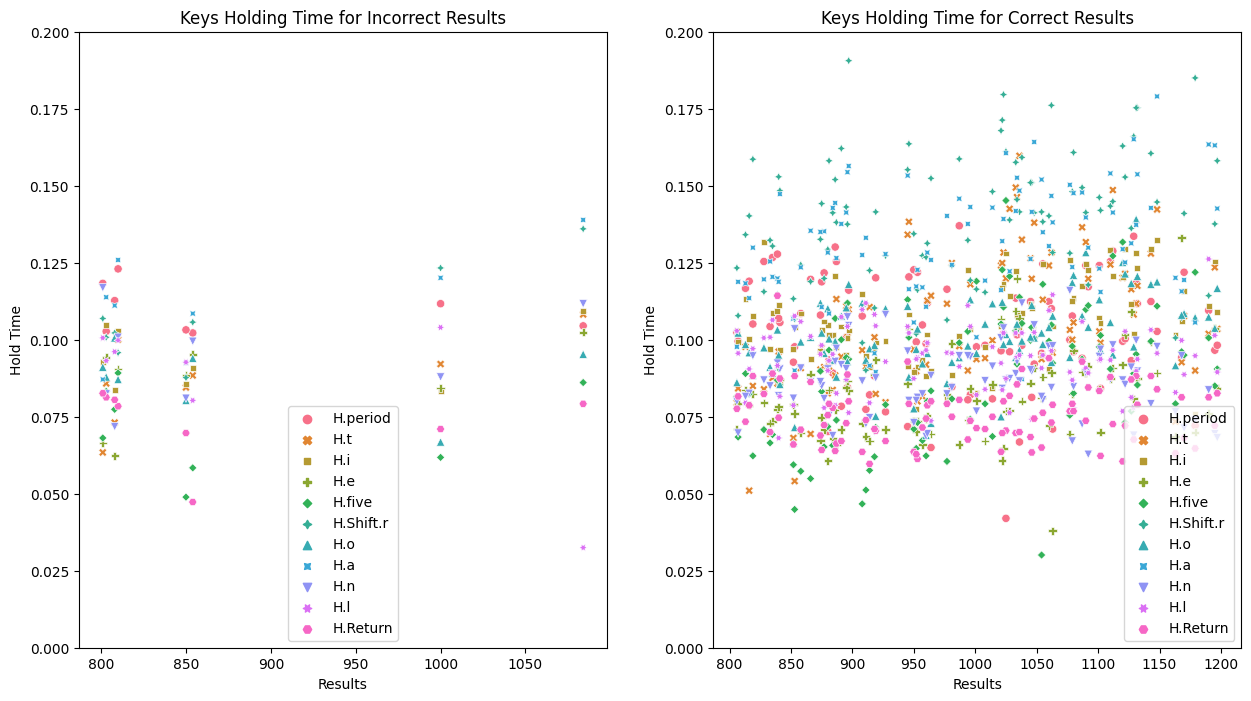

In [36]:
# Get their Hold times for comparison
hold_col = [x for x in df_s004.columns if x.startswith('H')]
hold_wrong_s004 = wrong_s004[hold_col]

# creating subplots to overlay the timings
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,8))

#for h in hold_col:
#    ax = sns.scatterplot(hold_df_s004, x=df_s004['results'], y=h)

ax = sns.scatterplot(hold_wrong_s004, ax=ax1)
ax = sns.scatterplot(correct_s004[hold_col], ax=ax2)

ax1.set(xlabel="Results", ylabel="Hold Time", title='Keys Holding Time for Incorrect Results', ylim=(0,0.2))
ax2.set(xlabel="Results", ylabel="Hold Time", title='Keys Holding Time for Correct Results', ylim=(0,0.2))
plt.show()


<b>Observations</b>: Comparison plotting between the incorrectly classified and correctly classified samples indicates that some distribution differences that might account for the reason why the model has failed to classified them correctly.  For example, the key hold duration for 'H.Shift.r' (Shift-R key press) is longer for those correctly classified samples than those which are incorrectly classified by the model.
In addition, the incorrectly classified samples tends to cluster around 4 sampling sessions as can be seen from the x-axis.  This might be due to some abnormal keypress from the subject during that particular session or day when data is captured.  

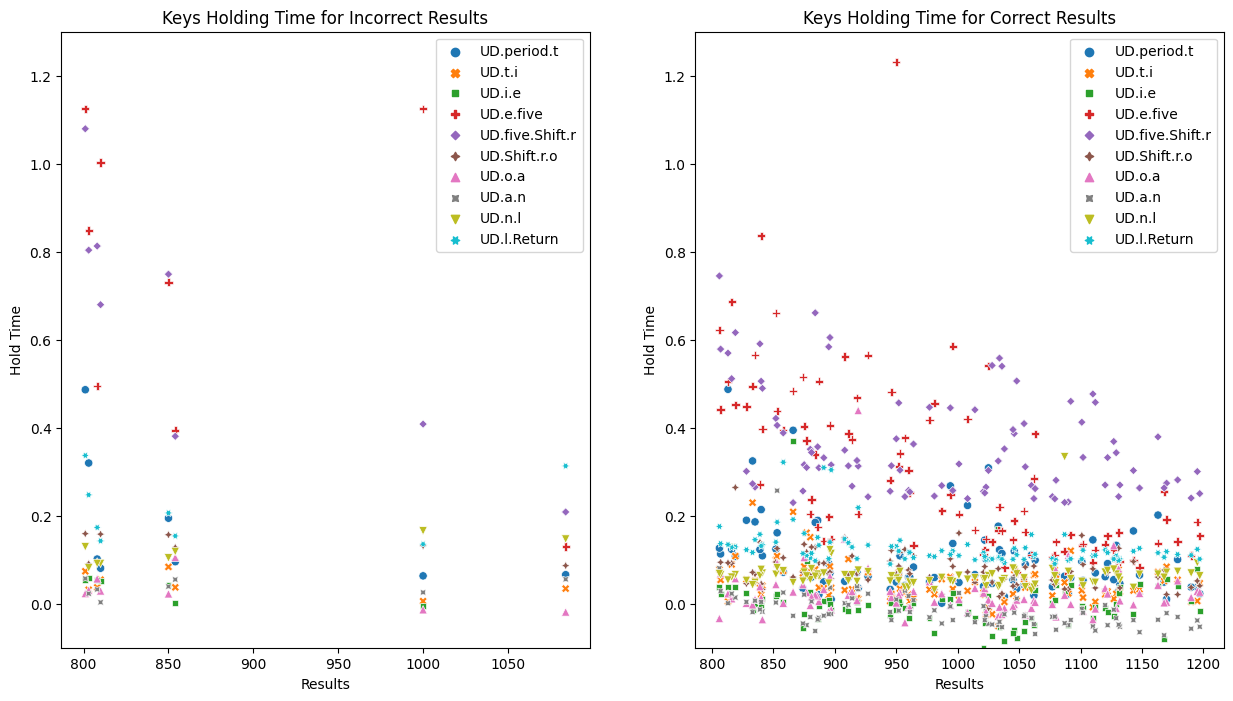

In [42]:
# Get their Up-to-Down times (key travel duration) for comparison
du_col = [x for x in df_s004.columns if x.startswith('UD.')]

# creating subplots to overlay the timings
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,8))

#for h in hold_col:
#    ax = sns.scatterplot(hold_df_s004, x=df_s004['results'], y=h)

ax = sns.scatterplot(wrong_s004[du_col], ax=ax1)
ax = sns.scatterplot(correct_s004[du_col], ax=ax2)

ax1.set(xlabel="Results", ylabel="Hold Time", title='Keys Holding Time for Incorrect Results', ylim=(-0.1,1.3))
ax2.set(xlabel="Results", ylabel="Hold Time", title='Keys Holding Time for Correct Results', ylim=(-0.1,1.3))
plt.show()


<p><b>Observations</b>: There are many samples with negative key travel timing in the correctly classified samples for this subject.  This suggests that the subject has pressed the next key before releasing the previous key in sequence.  This might be a characteristic of this particular subject.  For example, for the correctly classified samples on the right chart, the are many samples with negative values for UD.i.e (green) and UD.a.n. But this is not observed from the incorrectly classified samples on the left.  Hence, the subject's keystroke dynamic might not be consistent for those samples.</p>
<p>A possible solution to mitigate such abnormal sample might be to have subject performance the keystroke for a number of times and taking the average of the timing for prediction.  This might generate a more consistent outcome and improve accuracy in prediction.</p>

## Packaging the Finalised Trained Model For Deployment

In [11]:
# Fit encoder
enc = LabelEncoder()
enc.fit(df_target)

# Create pipeline
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('gboost', GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=300, subsample=0.9))])


# Fit Pipeline
pipeline.fit(X_train, y_train)

# Save encoder
filename1 = 'Model/encoder.sav'
pickle.dump(enc, open(filename1, 'wb'))

# Save model
filename2 = 'Model/finalized_model.sav'
pickle.dump(clf, open(filename2, 'wb'))
